## Accessing data via JASMIN Object Storage (using s3fs)

### Purpose: The purpose of this notebook is to demonstrate how to access data stored on Object Storage in NetCDF or csv.

#### Install packages if they are not present (use the package_installations.ipynb) https://datalab-docs.datalabs.ceh.ac.uk/object-storage/python.html

#####  Import the pre-requsites installed packages

In [1]:
import s3fs
import xarray as xr
import pandas as pd

from dask.distributed import Client

#####  Set up Dask Client (based on present cluster), this is done via the Dask tab in JupyterLab

In [2]:
##### Copy the DASK snippet from the DASK cluster three dots #####
# Paste this into your notebook cell
# Note that the Dask scheduler can be accessed from the Dask JupyterLab extension with address
# proxy/dask-scheduler-objstr:8787
# from dask.distributed import Client ### can comment this line as it is already imported in the cell above
c = Client("tcp://dask-scheduler-objstr:8786")
c

<Client: 'tcp://10.42.4.104:8786' processes=1 threads=2, memory=4.00 GiB>

##### Provide the address of the tenancy along with your credentials (these remain the same when opening all the next files)

In [3]:
s3 = s3fs.S3FileSystem(
    anon=False,
    key="f30b9a6dcf788205ea750181171ee6f2",
    secret="JlmhwdpbqqBqS3AW3dLgknsE0aB8raNQYemm9Psf",
    client_kwargs={"endpoint_url": "https://chess-scape-o.s3-ext.jc.rl.ac.uk"},
)

##### To open one single NetCDF file

In [4]:
f = s3.open("s3://testing-files/ecmwf_forecast_20210201_total-pr_monthly.nc", "rb")
f

<File-like object S3FileSystem, testing-files/ecmwf_forecast_20210201_total-pr_monthly.nc>

In [5]:
a = xr.open_dataset(f)
a

<xarray.Dataset>
Dimensions:    (longitude: 71, latitude: 76, number: 51, time: 2)
Coordinates:
  * longitude  (longitude) float32 -95.0 -94.0 -93.0 -92.0 ... -27.0 -26.0 -25.0
  * latitude   (latitude) float32 25.0 24.0 23.0 22.0 ... -48.0 -49.0 -50.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time       (time) datetime64[ns] 2021-02-01 2021-03-01
Data variables:
    tprate     (time, number, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-03 17:17:07 GMT by grib_to_netcdf-2.18.0: grib_to_n...

In [6]:
a["tprate"].shape

(2, 51, 76, 71)

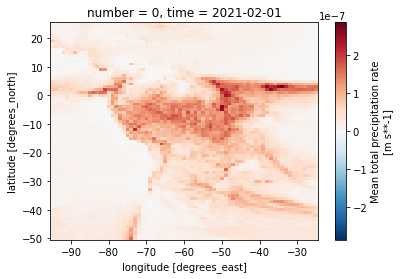

In [7]:
a["tprate"][0, 0, :, :].plot()

In [8]:
f = s3.open("s3://testing-files/ecmwf_system5_operational_20210101_sst_monthly.nc")
xr.open_dataset(f)

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 181, number: 51, time: 6)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-06-01
Data variables:
    sst        (time, number, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-20 12:04:19 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

##### To open multiple NetCDF files together

In [9]:
s3path = "s3://testing-files/ecmwf_system5_operational*"
remote_files = s3.glob(s3path)
remote_files

['testing-files/ecmwf_system5_operational_20210101_sst_monthly.nc',
 'testing-files/ecmwf_system5_operational_20210201_sst_monthly.nc']

In [10]:
# Iterate through remote_files to create a fileset
fileset = [s3.open(file) for file in remote_files]
f = xr.open_mfdataset(fileset, combine="nested", compat="override")
# f = xr.open_mfdataset(fileset, combine='by_coords') # can't use this because of time dimension for ECMWF data is not continous
f

<xarray.Dataset>
Dimensions:    (time: 7, longitude: 360, latitude: 181, number: 51)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-07-01
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
Data variables:
    sst        (time, number, latitude, longitude) float32 dask.array<chunksize=(7, 51, 181, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-20 12:04:19 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

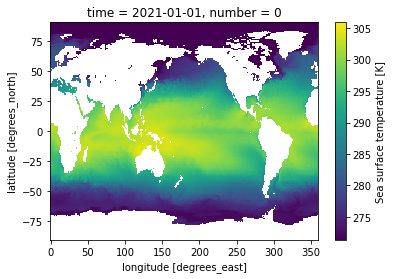

In [11]:
f["sst"].shape
f["sst"][0, 0, :, :].plot()

In [12]:
f["time"]

<xarray.DataArray 'time' (time: 7)>
array(['2021-01-01T00:00:00.000000000', '2021-02-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000', '2021-04-01T00:00:00.000000000',
       '2021-05-01T00:00:00.000000000', '2021-06-01T00:00:00.000000000',
       '2021-07-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-07-01
Attributes:
    long_name:  time

##### To open csv file

In [13]:
f = s3.open("s3://testing-files/metrics_score.csv")
pd.read_csv(f, delimiter=",", index_col=0)

,CC Score,RMSE Score
CHIRPS-ORI-Mar,43.00,19.13
CHIRPS-ORI-Feb,4.71,13.93
CHIRPS-SEAS-Feb,5.06,5.32
CHIRPS-MON-Feb,9.49,8.14
CHIRPS-CLIM-Feb,5.00,5.00
CMCC-Feb,14.18,7.03
DWD-Feb,8.11,6.25
ECMWF-Feb,43.27,17.94
METFR-Feb,11.41,9.53
NCEP-Feb,12.19,9.10


##### To open zarr files

In [14]:
# Method 1
f = s3.get_mapper("ac-files/01_pr_annualchunk.zarr")
a = xr.open_zarr(f)
a

/tmp/ipykernel_676/474647290.py:3: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  a = xr.open_zarr(f)


<xarray.Dataset>
Dimensions:  (y: 1057, x: 656, time: 36000)
Coordinates:
  * time     (time) object 1980-12-01 12:00:00 ... 2080-11-30 12:00:00
  * x        (x) float32 500.0 1.5e+03 2.5e+03 ... 6.535e+05 6.545e+05 6.555e+05
  * y        (y) float32 500.0 1.5e+03 2.5e+03 ... 1.054e+06 1.056e+06 1.056e+06
Data variables:
    lat      (y, x) float32 dask.array<chunksize=(1057, 656), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(1057, 656), meta=np.ndarray>
    pr       (time, y, x) float32 dask.array<chunksize=(360, 1057, 656), meta=np.ndarray>
Attributes:
    NCO:            4.7.3
    contact:        emrobi@ceh.ac.uk
    institution:    CEH Wallingford - NERC
    normalisation:  bias corrected against historical CHESS data
    project:        UK-SCAPE: SPEED

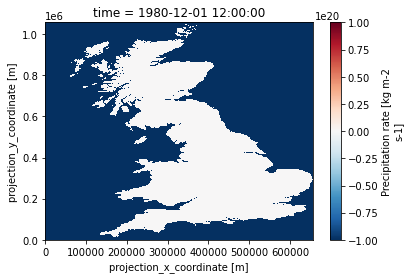

In [15]:
a["pr"][0, :, :].plot()

In [16]:
# Method 2
store = s3fs.S3Map(root="s3://ac-files/01_pr_annualchunk.zarr", s3=s3, check=False)
xr.open_zarr(store=store)

/tmp/ipykernel_676/2676400870.py:3: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  xr.open_zarr(store=store)


<xarray.Dataset>
Dimensions:  (y: 1057, x: 656, time: 36000)
Coordinates:
  * time     (time) object 1980-12-01 12:00:00 ... 2080-11-30 12:00:00
  * x        (x) float32 500.0 1.5e+03 2.5e+03 ... 6.535e+05 6.545e+05 6.555e+05
  * y        (y) float32 500.0 1.5e+03 2.5e+03 ... 1.054e+06 1.056e+06 1.056e+06
Data variables:
    lat      (y, x) float32 dask.array<chunksize=(1057, 656), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(1057, 656), meta=np.ndarray>
    pr       (time, y, x) float32 dask.array<chunksize=(360, 1057, 656), meta=np.ndarray>
Attributes:
    NCO:            4.7.3
    contact:        emrobi@ceh.ac.uk
    institution:    CEH Wallingford - NERC
    normalisation:  bias corrected against historical CHESS data
    project:        UK-SCAPE: SPEED

In [17]:
# Method 3
s3path = "s3://ac-files/0*_pr_annualchunk.zarr"
remote_files = s3.glob(s3path)
remote_files

['ac-files/01_pr_annualchunk.zarr',
 'ac-files/04_pr_annualchunk.zarr',
 'ac-files/06_pr_annualchunk.zarr']

In [18]:
# Iterate through remote_files to create a fileset
fileset = [s3.open(file) for file in remote_files]
fileset
f = xr.open_mfdataset(fileset)
f  # Xarray might not support multiple zarr files reading in but it does support multiple netcdf files (Matt B. thinks....check it out)

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [ ]:
# Method 4
# HOW TO USE DASK DISTRIBUTED???? Just added the client, does it work....ask Iain.